### Data engineering section:

Here we'll analyse the initial dataest and clean it to prepare for regression analysis of our target variable, house prices.

Note, there is a data description text file alongside the data to help make better data inferences.

In [1]:
import probscale
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

#### Data cleaning section: 

In [2]:
house_prices = pd.read_csv("data/house_prices.csv")
house_prices.head(10)

,Unnamed: 0,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
5,5,6,527105030,60,RL,78.0,9978,Pave,NaN,IR1,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500
6,6,7,527127150,120,RL,41.0,4920,Pave,NaN,Reg,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,213500
7,7,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500
8,8,9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,236500
9,9,10,527162130,60,RL,60.0,7500,Pave,NaN,Reg,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,189000


In [3]:
house_prices.drop('Unnamed: 0', axis=1, inplace=True)
house_prices.set_index('Order', inplace=True)

# replace any incorrect misssings with actual NAN values
house_prices = house_prices.replace(['NA', ''], np.NaN)

In [4]:
house_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2930 entries, 1 to 2930
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2930 non-null   int64  
 1   MS SubClass      2930 non-null   int64  
 2   MS Zoning        2930 non-null   object 
 3   Lot Frontage     2440 non-null   float64
 4   Lot Area         2930 non-null   int64  
 5   Street           2930 non-null   object 
 6   Alley            198 non-null    object 
 7   Lot Shape        2930 non-null   object 
 8   Land Contour     2930 non-null   object 
 9   Utilities        2930 non-null   object 
 10  Lot Config       2930 non-null   object 
 11  Land Slope       2930 non-null   object 
 12  Neighborhood     2930 non-null   object 
 13  Condition 1      2930 non-null   object 
 14  Condition 2      2930 non-null   object 
 15  Bldg Type        2930 non-null   object 
 16  House Style      2930 non-null   object 
 17  Overall Qual  

<AxesSubplot:xlabel='Order'>

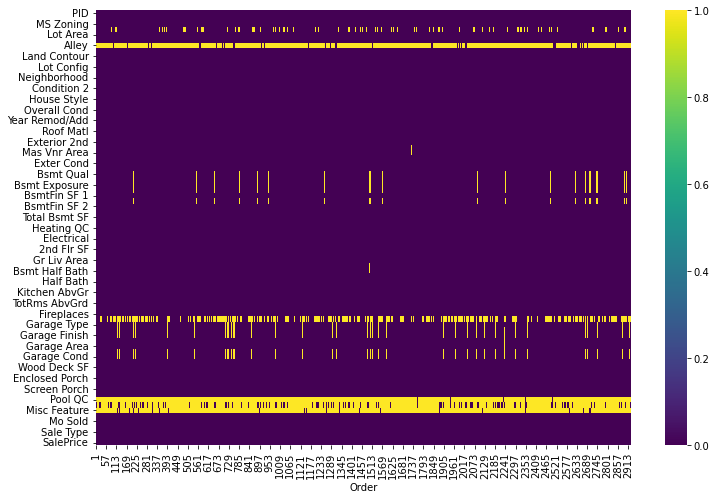

In [5]:
#  visualise missing data

plt.figure(figsize=(12,8))
sns.heatmap(house_prices.isna().transpose(), cmap="viridis")

Variables with a significant amount of values missing are: 

*  Alley
*  Pool QC 
*  Fence
*  Misc Feature

As such they will removed from the dataset completely to prevent the replacement for missing values being substantially wrong.

In [6]:
house_prices.drop(['Alley', 'Pool QC', 'Misc Feature', 'Fence'], axis=1, inplace=True)

MSZoning is a feature used to describe the type of sale i.e., agriculture, commerical, industrial or residential

As our regression model will focus on residential sales all other transactions will be dropped from our dataset.

In [7]:
house_prices['MS Zoning'].value_counts()

RL         2273
RM          462
FV          139
RH           27
C (all)      25
I (all)       2
A (agr)       2
Name: MS Zoning, dtype: int64

In [8]:
house_prices = house_prices[(house_prices['MS Zoning'] != 'C (all)') & (house_prices['MS Zoning'] != 'I (all)') & (house_prices['MS Zoning'] != 'A (agr)')]

#### Going from top to bottom of missing values based on house_prices.info() above:

In [9]:
house_prices[['Lot Frontage', 'Lot Area', 'Lot Shape']].groupby('Lot Shape').mean()

,Lot Frontage,Lot Area
Lot Shape,,
IR1,74.768760,11506.414959
IR2,67.437500,18913.065789
IR3,117.636364,32064.187500
Reg,66.821387,8849.153301


AxesSubplot(0.125,0.125;0.775x0.755)


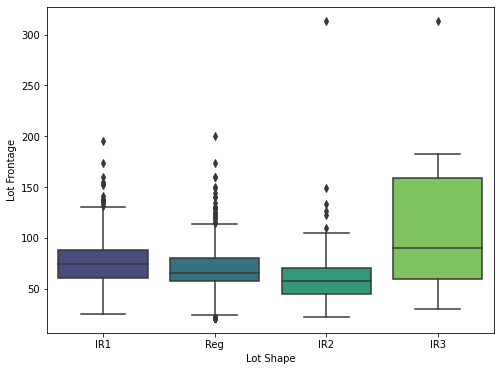

In [10]:
plt.figure(figsize=(8,6))
print(sns.boxplot(y=house_prices['Lot Frontage'],x=house_prices['Lot Shape'], palette="viridis"))

In [11]:
#  Clearly the lot footage and area is dependent on the lot shape, hence, for lot footage,
#  we will replace missing values with the average grouped by the lot shape. 

def replace_lot_frontage(cols):
    lot_frontage = cols[0]
    lot_shape = cols[1]
    
    if pd.isnull(lot_frontage):
        
        if lot_shape == 'IR1':
            return 74.81
        elif lot_shape == 'IR2':
            return 67.44
        elif lot_shape == 'IR3':
            return 117.64
        elif lot_shape == 'Reg':
            return 66.85
    # else      
    return lot_frontage

house_prices['Lot Frontage'] = house_prices[['Lot Frontage', 'Lot Shape']].apply(replace_lot_frontage, axis=1)

The next two variables with missing values are Mas Vnr Type (masonry veneer type) and Mas Vnr Area. In this case the missing values are in the exact same positions, and as None is a real value for masonry veneer type, we will assume that the missings are in fact equal to none too. This is a fair assumption on the basis that most residential sales do not have a masonry veneer.

Action: replace all nulls for mas vnr type with the most frequent value, 'None', then for mas vnr area take the average value for mas vnr type where it is equal to 'None'.

Some analysis below to support the above action:

In [12]:
house_prices['Mas Vnr Type'].value_counts()

None       1723
BrkFace     880
Stone       249
BrkCmn       25
CBlock        1
Name: Mas Vnr Type, dtype: int64

In [13]:
# return the number of rows missing
house_prices[(house_prices['Mas Vnr Type'].isnull()) & (house_prices['Mas Vnr Area'].isnull())].shape[0]

23

23 + 1,878 (non nulls as per house_prices.info() above) = 1,901 

Hence missing values for both variables are in the exactly same place. Moreover this is 1% of the total dataset so any change will need a have a huge impact on the final model outcome.

In [14]:
house_prices['Mas Vnr Type'].fillna('None', inplace=True)

In [15]:
#  get the mean of mas vnr type
house_prices[house_prices['Mas Vnr Type'] == 'None']['Mas Vnr Area'].mean()

0.7150319210679048

In [16]:
# replace missings in mas vnr area with the above
house_prices['Mas Vnr Area'].fillna(0.715, inplace=True)

The remaining variables with missing values are categorical and as per the description.txt, we know these missing values show the feature does *not* exist and is not in fact a missing value due to an input error. The numerical variables linked with this categorical variable are not missing and as such as we do not need to perform any engineering for now. Evidence to support this:

In [17]:
#  bsmt qual is null means no basement, hence area is obviously 0 as shown
house_prices[house_prices['Bsmt Qual'].isnull()][['BsmtFin SF 1']].value_counts()

BsmtFin SF 1
0.0             75
dtype: int64

In [18]:
# the same can be shown for garage quality i.e., null values mean no garage area
house_prices[house_prices['Garage Qual'].isnull()][['Garage Area']].value_counts()

Garage Area
0.0            147
360.0            1
dtype: int64

### Searching for outliers 

Here we'll focus our attention on the target variable plus variables displaying the size and area of the property, which will clearly have one of the largest impacst on the sale price. Values +- 3 standard deviations from the mean are considered to be outliers and hence will be dropped from the dataset.

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

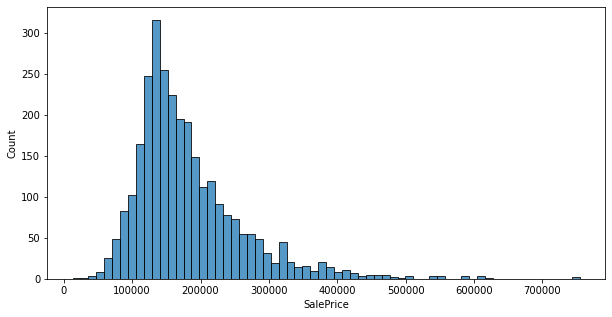

In [19]:
# as per the below the target is clearly non-gaussian as a result of the positive skewness. Keeping the high outliers in our dataset will likely skew the predictions on the positive side leading 
# to overestimated property prices.
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(x=house_prices.SalePrice, ax=ax)

In [20]:
# 45 sale prices greater than 3 standard deviations of the mean.
house_prices.SalePrice[(house_prices.SalePrice > np.mean(house_prices.SalePrice) + 3 * np.std(house_prices.SalePrice))].count()

45

In [21]:
# 0 sale prices less than 3 standard deviations from the mean.
house_prices.SalePrice[(house_prices.SalePrice < np.mean(house_prices.SalePrice) - 3 * np.std(house_prices.SalePrice))].count()

0

<AxesSubplot:xlabel='Gr Liv Area', ylabel='Count'>

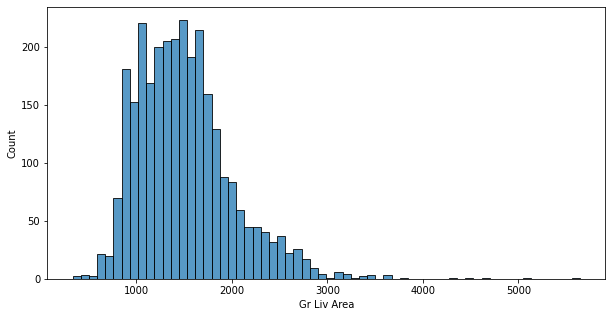

In [22]:
# similarly to sale prices, ground living area is also not normally distributed as a result of the positive skewness. Note that variables 1st & 2nd floor square feet are just the sum of the 
# ground living area hence they do not need to be analysed independently for outliers.
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(house_prices['Gr Liv Area'], ax=ax)

In [23]:
# 25 rows where ground living area is greater than 3 standard deviations above the mean
house_prices['Gr Liv Area'][(house_prices['Gr Liv Area'] > np.mean(house_prices['Gr Liv Area']) + 3 * np.std(house_prices['Gr Liv Area']))].count()

25

In [24]:
# and 0 in the opposite direction
house_prices['Gr Liv Area'][(house_prices['Gr Liv Area'] < np.mean(house_prices['Gr Liv Area']) - 3 * np.std(house_prices['Gr Liv Area']))].count()

0

In [25]:
# dropping houses where sale prices above 3 stds from the mean, as per the above
df = house_prices[house_prices.SalePrice < (np.mean(house_prices.SalePrice) + 3*np.std(house_prices.SalePrice))]

In [26]:
# dropping houses where ground living area is above 3 stds from the mean
df = df[(df['Gr Liv Area'] < (np.mean(df['Gr Liv Area']) + 3 * np.std(df['Gr Liv Area'])))]

65 rows were removed as a result of the above, amounting to approximately 2.24% of the total dataset.

As displayed below, while data is still skewed, removing the outliers has made the distributions closer to that of a bell-curve. The implication here is that model predictions will be more accurate with less variance, also shown below. 

However, a noteworthy consequence of dropping the high sale price values is that the model has reduced its range in which to make predictions, hence, for high-valued properties the model we select will most likely be inaccurate.

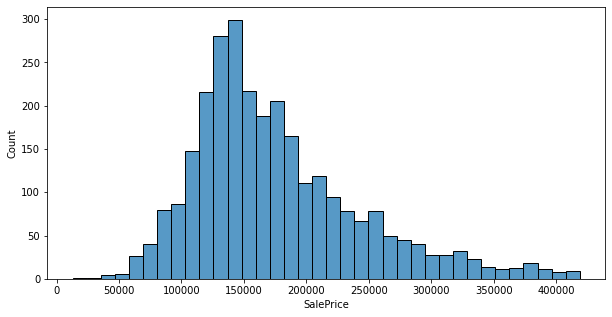

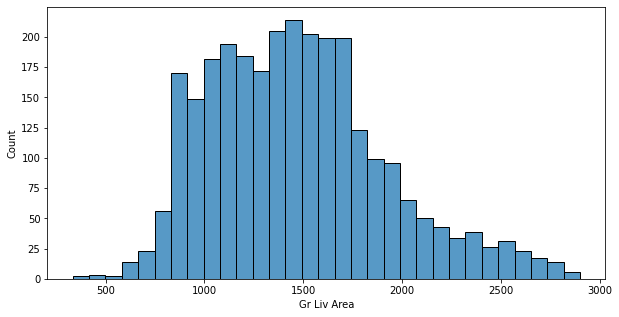

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(df['SalePrice'], ax=ax)

fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(df['Gr Liv Area'], ax=ax)
plt.show()

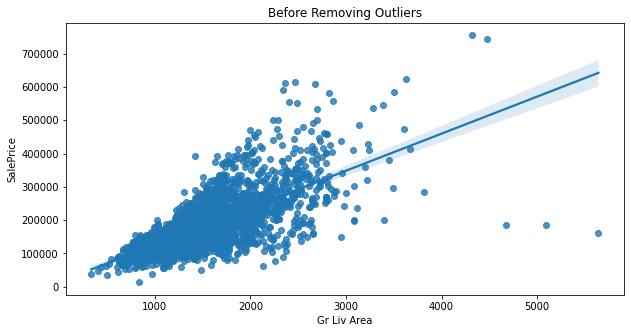

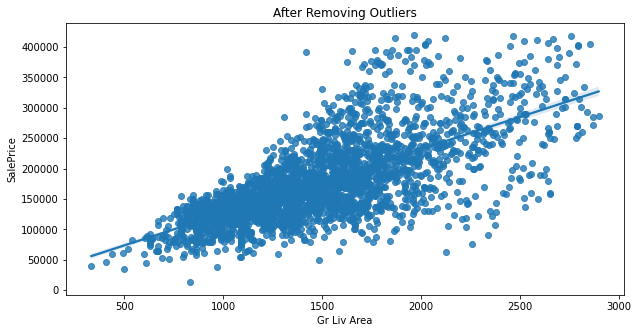

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(data=house_prices, x="Gr Liv Area", y='SalePrice', ax=ax)
plt.title("Before Removing Outliers")

fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(data=df, x="Gr Liv Area", y='SalePrice', ax=ax)
plt.title("After Removing Outliers")
plt.show()

#### Sale Condition variable:

As per the description there is also a variable named sale condition which describes the condition under which the sale was completed. Interestingly when grouped separately these sales deviate from the measures of central tendency of properties sold under normal conditions:

In [29]:
df['Sale Condition'].value_counts()

Normal     2364
Partial     221
Abnorml     174
Family       44
Alloca       21
AdjLand      12
Name: Sale Condition, dtype: int64

In [30]:
df[['SalePrice', 'Sale Condition']].groupby('Sale Condition').mean()

,SalePrice
Sale Condition,
Abnorml,136119.212644
AdjLand,108916.666667
Alloca,162810.380952
Family,154383.522727
Normal,172528.434433
Partial,254089.384615


<AxesSubplot:xlabel='Sale Condition', ylabel='SalePrice'>

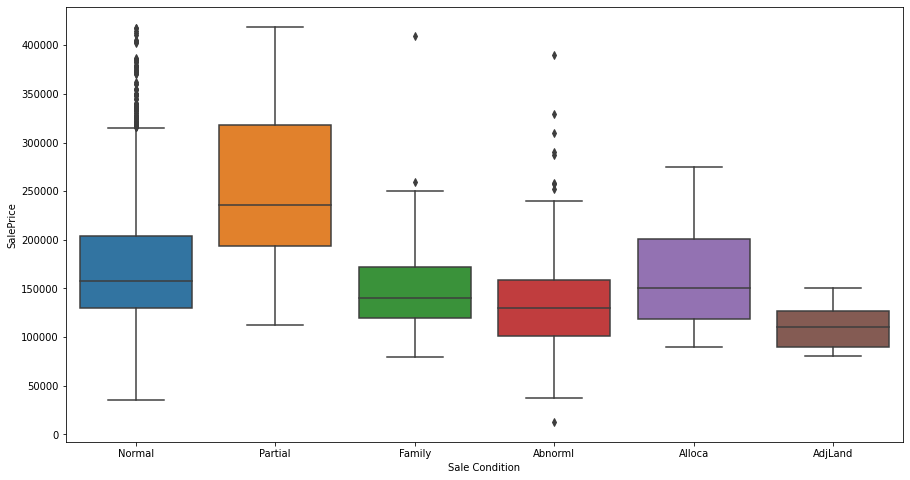

In [31]:
plt.figure(figsize=(15,8))
sns.boxplot(x=df['Sale Condition'], y=df['SalePrice'])

In [32]:
print("Data size (%): " , df[df['Sale Condition'].isin(['Abnorml', 'Family', 'AdjLand'])]['Sale Condition'].count() / df.shape[0] * 100)

Data size (%):  8.110014104372356


It is clear that houses sold under the condition of family, abnormal or adjoining land purchase have sale prices significantly less than those sold under normal conditions. Hence, running these values through the model is likely to introduce bias. For example, houses sold between family members could have been sold for less than market value which may explain the average sale-price being less. This applies to abnormal conditions (trade, foreclosure or short sale) and adjoining land purchases too.

While removing 8% of the dataset is significant, we want our model to predict house prices that reflect *true* market and economic conditions. Consequently, these sales will be dropped from our dataset.

Note that partial sales refers to the sale of *new* properties which explains their high sale prices.

In [33]:
df = df[~df['Sale Condition'].isin(['Abnorml', 'Family', 'AdjLand'])]

**As a result of our above data cleaning, approximately 10% of all data has been removed.**

### Feature Engineering:

In [34]:
# simplify year built into age variable
df['Age'] = df['Year Built'].apply(lambda x: 2022-x)

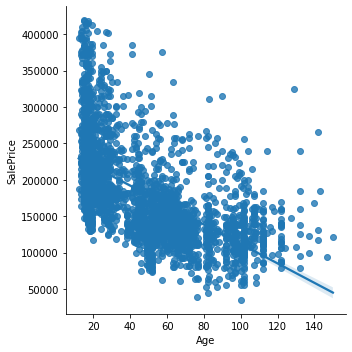

In [35]:
sns.lmplot(data=df, x='Age', y='SalePrice')

Age is clearly negatively correlated with the price of property i.e., the newer the property the higher its price.

In [36]:
# analysing the neighborhood variable, likely to have a large impact on the sale price
df[['SalePrice', 'Neighborhood']].groupby('Neighborhood').mean().sort_values(by='SalePrice', ascending=False)

,SalePrice
Neighborhood,
NoRidge,302810.966667
NridgHt,293799.936170
GrnHill,280000.000000
StoneBr,277356.512821
Veenker,255865.909091
Timber,247174.134328
Somerst,228095.529070
ClearCr,215045.578947
Crawfor,205801.446809


In [37]:
df.Neighborhood.value_counts()

NAmes      395
CollgCr    257
OldTown    204
Somerst    172
Edwards    160
Gilbert    158
NridgHt    141
Sawyer     137
SawyerW    118
NWAmes     117
Mitchel    103
BrkSide     98
Crawfor     94
Timber      67
NoRidge     60
IDOTRR      56
SWISU       39
StoneBr     39
ClearCr     38
MeadowV     34
Blmngtn     28
BrDale      26
NPkVill     22
Veenker     22
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

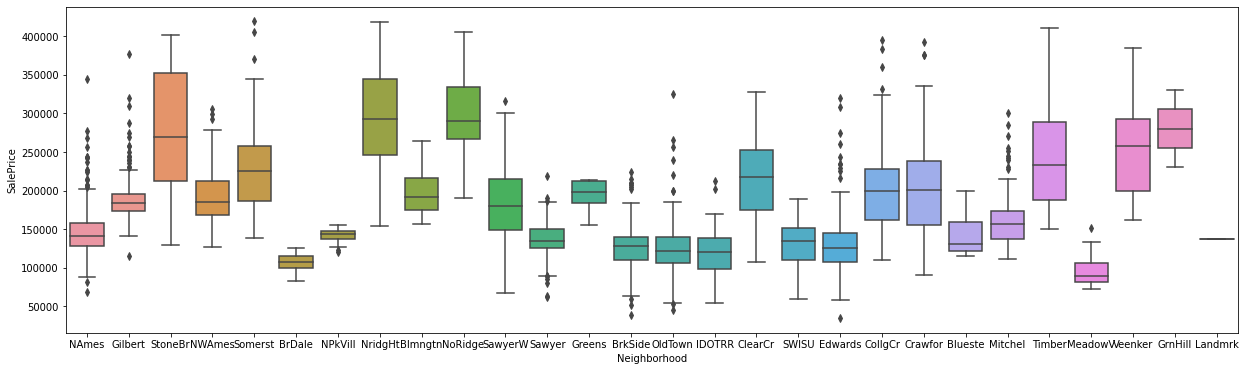

In [38]:
plt.figure(figsize=(21,6))
sns.boxplot(x=df.Neighborhood, y=df.SalePrice)

In [39]:
df.Neighborhood.nunique()

28

It's clear from the above box plot that the location of the property has an impact on its price, consequently this would be a useful feature to use in our regression analysis.

However, as there are so many unique values (28 in total) creating dummy variables through one-hot encoding is unlikely to be the best engineering method as the input data is extremely wide. This is especially concerning as neighborhoods are not equally represented e.g., the top 5 most popular neighborhoods make up for nearly 50% of all property sales. Hence, leaving this variable as is will add bias to the model and neighborhoods unequally represented are likely to have inaccurate price predictions.

**Solution:**

Similarly to the problem of predicting car prices based on the make/model of the vehicle, it's reasonable to assume that the more desirable the vehicle the higher it's overall quality and condition. Reviewing the description file we see that we have variables that show this information: 

* Overall Qual - rates the overall material and finish of the house from 1-10, 10 being the best condition
* Overall Cond - rates the overall house cond. from 1-10, 10 being the best
* Exter Qual - rates the overall quality of the exterior material, 'Ex' being best for excellent
* Exter Cond - rates the present condition of the exterior material, 'Ex' being best for excellent
* Kitchen Qual - rates the overal material and finish of the kitchen
* Functional - rates the current functionality of the property i.e., from typical being best to salvage (e.g, needs complete refurb)

Using these six variables, we will create our own overall condition variable as a proxy for the location and analyse if this trend is approximately correct. if it is, we'll use this as a replacement for the neighborhood variable.

For this, we first need to change the last four variables listed above to numerical format:

In [40]:
def replace_functional_vals(value):
    """
    Used to replace the functional variable that represents how functional the property is currently
    """
    
    if value == 'Typ':
        return 8
    elif value == 'Min1':
        return 7
    elif value == 'Min2':
        return 6
    elif value == 'Mod':
        return 5
    elif value == 'Maj1':
        return 4
    elif value == 'Maj2':
        return 3
    elif value == 'Sev':
        return 2
    # else value == 'Sal' for salvage only    
    else:
        return 1
    
def replace_discrete_variables(value):
    """ 
    Used for replacing the following categorical variables to numerics: Exter Qual, Exter Cond and KitchenQual    
    """
    if value == 'Ex':
        return 5
    elif value == 'Gd':
        return 4
    elif value == 'TA':
        return 3     
    elif value == 'Fa':
        return 2
    # else value == 'poor', return 1
    else:
        return 1

In [41]:
df['Functional_Num'] = df['Functional'].apply(replace_functional_vals)
df['KitchenQual_Num'] = df['Kitchen Qual'].apply(replace_discrete_variables)
df['ExterCond_Num'] = df['Exter Cond'].apply(replace_discrete_variables)
df['ExterQual_Num'] = df['Exter Qual'].apply(replace_discrete_variables)

In [42]:
# testing changes against previous values
print(df['ExterCond_Num'].value_counts())
print(df['Exter Cond'].value_counts())
print()
print(df['ExterQual_Num'].value_counts())
print(df['Exter Qual'].value_counts())
print()
print(df['KitchenQual_Num'].value_counts())
print(df['Kitchen Qual'].value_counts())

3    2277
4     266
2      50
5      11
1       2
Name: ExterCond_Num, dtype: int64
TA    2277
Gd     266
Fa      50
Ex      11
Po       2
Name: Exter Cond, dtype: int64

3    1580
4     929
5      73
2      24
Name: ExterQual_Num, dtype: int64
TA    1580
Gd     929
Ex      73
Fa      24
Name: Exter Qual, dtype: int64

3    1308
4    1087
5     151
2      59
1       1
Name: KitchenQual_Num, dtype: int64
TA    1308
Gd    1087
Ex     151
Fa      59
Po       1
Name: Kitchen Qual, dtype: int64


In [43]:
df['LocationProxy'] = (
    # standardise the values by the average value
    df['Overall Qual'] / df['Overall Qual'].mean() + 
    df['Overall Cond'] / df['Overall Cond'].mean() + 
    df['ExterCond_Num'] / df['ExterCond_Num'].mean() +
    df['ExterQual_Num'] / df['ExterQual_Num'].mean() +
    df['KitchenQual_Num'] / df['KitchenQual_Num'].mean() +
    df['Functional_Num'] / df['Functional_Num'].mean()
)

In [44]:
# determine if the new location proxy makes sense
df[['SalePrice', 'Neighborhood', 'LocationProxy']].groupby('Neighborhood').mean().sort_values(by='SalePrice', ascending=False)

,SalePrice,LocationProxy
Neighborhood,,
NoRidge,302810.966667,6.521670
NridgHt,293799.936170,6.735466
GrnHill,280000.000000,6.342510
StoneBr,277356.512821,6.606426
Veenker,255865.909091,6.583199
Timber,247174.134328,6.342820
Somerst,228095.529070,6.424677
ClearCr,215045.578947,5.918974
Crawfor,205801.446809,6.102384


The newly created variable makes sense in that as property prices increase, so too does the location proxy variable based on the current condition of the property. 

Using the analysis above, it's possible to transform the variable to an ordinal measurement by grouping neighborhoods with similar values to further separate the location proxy. Like the example given above for predicting the prices of vehicles, this would be like grouping cars in subsets such as German-made, as their demand will tend to be similar irrespective of the actual make.

In this example, as we have an even number of neighborhoods, we'll create 4 equally sized groups, where 1 represents the least popular neighborhoods and 4 represents the most in demand neighborhoods.

In [45]:
# testing location proxy to determine if it makes sense
df[['Neighborhood', 'LocationProxy']].groupby('Neighborhood').mean().sort_values(by='LocationProxy', ascending=False)

,LocationProxy
Neighborhood,
NridgHt,6.735466
StoneBr,6.606426
Veenker,6.583199
NoRidge,6.521670
Greens,6.515220
Somerst,6.424677
Blmngtn,6.376068
Timber,6.342820
GrnHill,6.342510


In [46]:
def group_neighborhoods(neighborhood):

    if neighborhood in ['MeadowV', 'Landmrk', 'Edwards', 'SWISU', 'Sawyer', 'IDOTRR', 'BrDale']:
        return 1
    elif neighborhood in ['BrkSide', 'NAmes', 'Mitchel', 'NPkVill', 'OldTown', 'ClearCr', 'NWAmes']:
        return 2
    elif neighborhood in ['Gilbert', 'Blueste', 'SawyerW', 'Crawfor', 'CollgCr', 'GrnHill', 'Timber']:
        return 3
    return 4

In [47]:
df['LocationProxy'] = df['Neighborhood'].apply(group_neighborhoods)

In [48]:
df.LocationProxy.value_counts()

2    977
3    706
4    470
1    453
Name: LocationProxy, dtype: int64

In [49]:
df[['SalePrice', 'LocationProxy', 'Gr Liv Area', 'Age']].groupby('LocationProxy').mean()

,SalePrice,Gr Liv Area,Age
LocationProxy,,,
1,127422.044150,1244.834437,66.704194
2,149734.678608,1374.401228,67.671443
3,199843.361190,1578.726629,32.433428
4,260271.512766,1764.214894,20.278723


The new location proxy variable is clearly better at predicting prices than the previous version. We can see this as the ordinal measurment increases so too does the sale price and size of the ground living area. Age decreases which we'd expect based on our above analysis (age is negatively correlated with sale price).

While we're now limiting our model predictions for outputs based on exact neighborhoods, we've removed most of the bias from our model as all groups are now represented adequately. As also mentioned above, creating this new variable has reduced the noise in our model as input data is no longer wide for this variable - from 28 values we've created 4.

Now reviewing the condition of the property based on its surrounding area e.g., nearby railroads, busy streets etc.

In [50]:
df[['SalePrice', 'Condition 1']].groupby('Condition 1').mean()

,SalePrice
Condition 1,
Artery,127510.000000
Feedr,146903.063830
Norm,182601.927337
PosA,222963.888889
PosN,217416.939394
RRAe,138776.000000
RRAn,180150.000000
RRNe,150337.500000
RRNn,206906.250000


<AxesSubplot:xlabel='Condition 1', ylabel='SalePrice'>

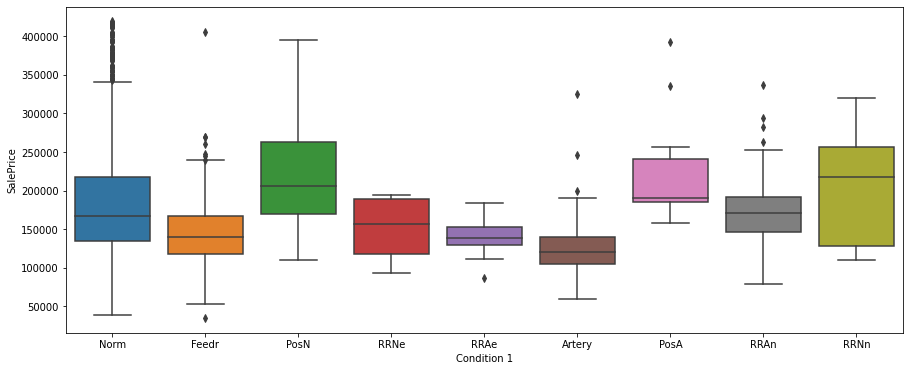

In [51]:
plt.figure(figsize=(15,6))
sns.boxplot(x=df['Condition 1'], y=df['SalePrice'])

In [52]:
df['Condition 1'].value_counts()

Norm      2257
Feedr      141
Artery      75
RRAn        45
PosN        33
RRAe        25
PosA        18
RRNn         8
RRNe         4
Name: Condition 1, dtype: int64

There are an overwhelming majority of properties sold under normal conditions and as a result leaving the values as they are, similarly to neighborhood, would add bias to the model. 

Knowing that the Ames dataset contains the sale of properties in Iowa, a midwestern state in America not close to any popular cities commutable by train, it's extremely likely that the nearby railway links are not desirable i.e., they are not for public transport but for moving goods across the country (if however we were reviewing the property prices of say, New York, the railway would likely be desirable nearby).

As a result, we'll group properties together based on whether or not they are close to a railway or a busy street. As seen above, the results show mostly that these properties sell for the least which makes sense due to both air and noise pollution.

In [53]:
df['closeToRailOrRoad1'] = df['Condition 1'].apply(lambda x: 1 if x in ['Artery', 'Feedr', 'RRNn', 'RRAn', 'RRNe', 'RRAe'] else 0)
df['closeToRailOrRoad2'] = df['Condition 2'].apply(lambda x: 1 if x in ['Artery', 'Feedr', 'RRNn', 'RRAn', 'RRNe', 'RRAe'] else 0)

In [54]:
df['closeToRailorRoad'] = df.apply(lambda df: 1 if (df['closeToRailOrRoad1'] == 1 | df['closeToRailOrRoad2'] == 1) else 0, axis=1)

In [55]:
df[['SalePrice', 'closeToRailorRoad']].groupby('closeToRailorRoad').mean()

,SalePrice
closeToRailorRoad,
0,183414.496967
1,148017.892617


In [56]:
df[['SalePrice', 'LocationProxy','closeToRailorRoad']].groupby(['closeToRailorRoad', 'LocationProxy']).mean()

SalePrice
closeToRailorRoad LocationProxy               
0                 1              128086.700265
                  2              152220.179302
                  3              202083.036810
                  4              260667.107143
1                 1              124125.000000
                  2              135587.753425
                  3              172801.351852
                  4              252215.772727

The analysis above confirms the new variable is a good indicator of price based on whether the property is near a railway or busy road. More granularly, we can see that, if two properties are in the same neighborhood or very close, but one does not have a railway or road nearby, then it is more desirable indicated by the sale price.

Now reviewing and cleaning up the MS Zoning variable:

In [57]:
df[['SalePrice', 'MS Zoning']].groupby('MS Zoning').mean()

,SalePrice
MS Zoning,
FV,219705.894737
RH,130250.000000
RL,187264.993649
RM,128750.406404


Clearly the type of residential property for sale has an impact on the price. In this case properties built on water (floating village residential) are most desirable. Properties then decrease in price as population density increases hence the correlation is negative i.e., the more people live in an particular area the less the property's value.

Similarly to the location proxy, we'll create an ordinal variable named 'area_density' to display the density of the area around the property, in this case we assume that FV is the least densely populated as the property is built on water.

In [58]:
def create_pop_density(zone):
    
    if zone == 'FV':
        return 4
    elif zone == 'RL':
        return 3
    elif zone == 'RM':
        return 2
    elif zone == 'RH':
        return 1

df['pop_density'] = df['MS Zoning'].apply(create_pop_density)

<AxesSubplot:xlabel='pop_density', ylabel='SalePrice'>

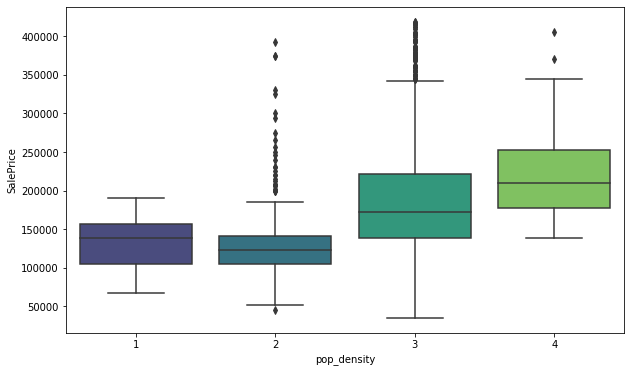

In [59]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['pop_density'], y=df['SalePrice'], palette="viridis")

Reviewing the year properties were sold:

In [60]:
df['Yr Sold'].value_counts()

2007    629
2009    583
2008    552
2006    534
2010    308
Name: Yr Sold, dtype: int64

In [61]:
df[['Yr Sold', 'SalePrice']].groupby('Yr Sold').mean()

,SalePrice
Yr Sold,
2006,181239.910112
2007,180141.365660
2008,179906.425725
2009,179496.989708
2010,173324.246753


In [62]:
df[['Yr Sold', 'SalePrice']].groupby('Yr Sold').mean().pct_change()*100

,SalePrice
Yr Sold,
2006,NaN
2007,-0.606127
2008,-0.130420
2009,-0.227583
2010,-3.438912


As a result of the financial crisis property prices significantly declined. Therfore it may be useful to add this data into the model as a dummy variable based on economic conditions e.g., is the current market more closely aligned with that prior to or post the financial crisis? In this case it may have been useful to have more data leading up to the crisis i.e., before 2006, rather than just years either side. 

In [67]:
df = pd.concat([df, pd.get_dummies(df['Yr Sold'], prefix='YrSold')], axis=1)

Performing further engineering though more minor i.e., just converting categorical variables to binary or ordinal outcome 

In [63]:
df['Central Air'].value_counts()

Y    2462
N     144
Name: Central Air, dtype: int64

In [64]:
df['Central Air'] = df['Central Air'].apply(lambda x: 1 if x == 'Y' else 0)

In [65]:
df['Paved Drive'].value_counts()

Y    2379
N     167
P      60
Name: Paved Drive, dtype: int64

In [66]:
df[['SalePrice', 'Paved Drive']].groupby('Paved Drive').mean()

,SalePrice
Paved Drive,
N,113757.371257
P,136108.400000
Y,185063.474569


In [67]:
# Creating a binary column that shows if the property is located near a postive amentity e.g., a park, greenbelt etc.
df['closeToPosAmentity1'] = df['Condition 1'].apply(lambda x: 1 if x in ['PosN', 'PosA'] else 0)
df['closeToPosAmentity2'] = df['Condition 2'].apply(lambda x: 1 if x in ['PosN', 'PosA'] else 0)

df['closeToAmentity'] = df.apply(lambda df: 1 if (df['closeToPosAmentity1'] == 1 | df['closeToPosAmentity2'] == 1) else 0, axis=1)

In [68]:
df.drop(['closeToPosAmentity1', 'closeToPosAmentity2'], axis=1, inplace=True)

In [69]:
# dropping the utitilities variable as all have full public utitilities and consequently we receive no meaning from this variable
df.drop('Utilities', axis=1, inplace=True)

In [70]:
df['Street'].value_counts()

Pave    2600
Grvl       6
Name: Street, dtype: int64

In [71]:
df['streetIsPaved'] = df['Street'].apply(lambda x: 1 if x =='Pave' else 0)

In [72]:
df.drop('Street', axis=1, inplace=True)

In [73]:
df[['Bldg Type', 'SalePrice']].groupby('Bldg Type').mean()

,SalePrice
Bldg Type,
1Fam,182669.705033
2fmCon,125262.807692
Duplex,142399.714286
Twnhs,136770.322581
TwnhsE,192987.160714


Clearly the type of dwelling has an impact on the average price of the property as shown by the above variation. Consequently we'll create dummy variables from this variable:

In [74]:
df = pd.concat([df, pd.get_dummies(df['Bldg Type'], prefix="BldingType")], axis=1)

Creating a new variable for total bathrooms rather than having two individual columns:

In [75]:
df['Full Bath'].value_counts()

2    1398
1    1153
3      40
0      11
4       4
Name: Full Bath, dtype: int64

In [76]:
df['Half Bath'].value_counts()

0    1635
1     950
2      21
Name: Half Bath, dtype: int64

In [77]:
# creating a variable for the number of bathrooms. In this case half bathrooms are halved to find the sum
df['Bathrooms'] = df['Full Bath'] + (0.5 * df['Half Bath'])

In [78]:
df.drop(['Full Bath', 'Half Bath'], axis=1, inplace=True)

In [79]:
df[['Lot Config', 'SalePrice']].groupby('Lot Config').mean()

,SalePrice
Lot Config,
Corner,181163.036364
CulDSac,207753.262821
FR2,177361.825000
FR3,205684.769231
Inside,176549.764215


In [80]:
# creating a dummy variable for garage, if pd.isnull(x) then there is no garage
df['hasGarage'] = df['Garage Type'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [81]:
df[['Land Contour', 'SalePrice']].groupby('Land Contour').mean()

,SalePrice
Land Contour,
Bnk,147620.851064
HLS,233025.359223
Low,207539.280000
Lvl,177691.841882


In [82]:
df['Land Contour'].value_counts()

Lvl    2359
HLS     103
Bnk      94
Low      50
Name: Land Contour, dtype: int64

The analysis above shows there is variance in the price of a property based on how flat the land contour is surrounding the property. In the above case, we see that hillside properties receive the greatest price while banked properties, those with quick and signifcant rises from street to building, are the least desirable.

The above is still however biased towards flat properties, most in the area observed are near flat or level. Hence, leaving the variable as will create some model bias despite all values observed being greater than 30 in size (the minimum rule of thumb for the central limit theorem to hold). Consequently, we'lll do the following:

1. Create a new column with a binary outcome based on whether the land contour is flat (1) or not (0). 
2. Turn the variable into a dummy variable also to analyse the prices on a more granularly level:

In [83]:
# create binary outcome
df['flatContour'] = df['Land Contour'].apply(lambda x: 1 if x =='Lvl' else 0)

# create dummy variable spreading the variables across multiple new columns
df = pd.concat([df, pd.get_dummies(df['Land Contour'], prefix="LandContour")], axis=1)

In [84]:
# create dummy variable for kitchen
df = pd.concat([df, pd.get_dummies(df['Kitchen Qual'], prefix="kitchen")], axis=1)

#### Transforming the target variable:

Finally as observed above, while removing outliers in the target variable made the data appear more normal, there is still skewness as observed by the right tail:

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

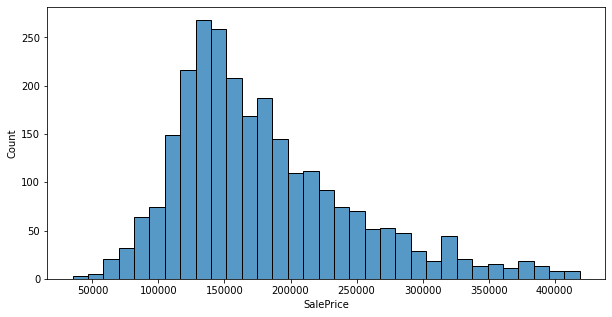

In [86]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(df['SalePrice'], ax=ax)

The non-normality of this variable can be confirmed using a probability plot (Q-Q plot) which compares two probability distributions by plotting their quantiles against each other, in this case we are comparing our sale prices against a normal distribution:

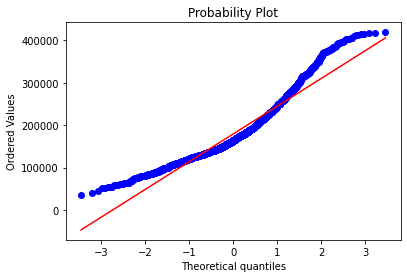

In [87]:
stats.probplot(df.SalePrice, dist="norm", plot=plt)
plt.show()

As we can see the data is skewed with tails on either side that are asymetrical and consequently the shape of this distribution does not well fit that of a gaussian distribution.

A solution to this issue is transforming the sale price using the natural logarithm which will reduce the positive skewness. Furthermore, as the prices are all non-zero positive values, this transformation method is appropiate:

In [88]:
df['LnSalePrice'] = np.log(df['SalePrice'])

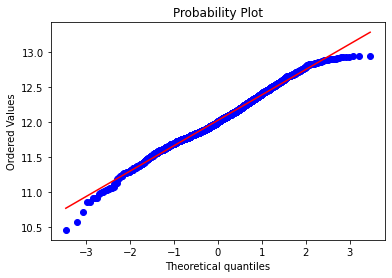

In [89]:
stats.probplot(df.LnSalePrice, dist="norm", plot=plt)
plt.show()

<AxesSubplot:xlabel='LnSalePrice', ylabel='Count'>

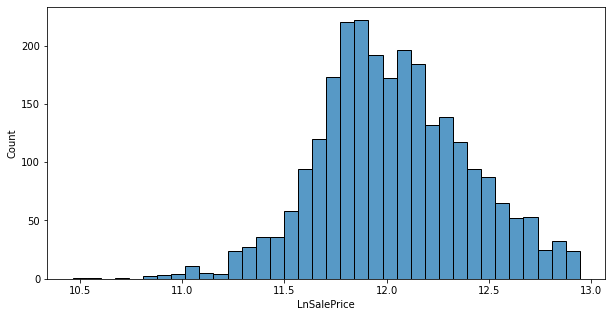

In [90]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(df['LnSalePrice'], ax=ax)

While there is still skewness in the natural log of sale prices, we can see from the Q-Q plot above that data is more symmetrical and consequently better fits a normal distribution.

### Exporting data:

In [91]:
pd.options.display.max_columns = None
df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Land Contour,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Age,Functional_Num,KitchenQual_Num,ExterCond_Num,ExterQual_Num,LocationProxy,closeToRailOrRoad1,closeToRailOrRoad2,closeToRailorRoad,pop_density,closeToAmentity,streetIsPaved,BldingType_1Fam,BldingType_2fmCon,BldingType_Duplex,BldingType_Twnhs,BldingType_TwnhsE,Bathrooms,hasGarage,flatContour,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,kitchen_Ex,kitchen_Fa,kitchen_Gd,kitchen_Po,kitchen_TA,LnSalePrice
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,20,RL,141.0,31770,IR1,Lvl,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,1,SBrkr,1656,0,0,1656,1.0,0.0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,0,5,2010,WD,Normal,215000,62,8,3,3,3,2,0,0,0,3,0,1,1,0,0,0,0,1.0,1,1,0,0,0,1,0,0,0,0,1,12.278393
2,526350040,20,RH,80.0,11622,Reg,Lvl,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,1,SBrkr,896,0,0,896,0.0,0.0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,105000,61,8,3,3,3,2,1,0,1,1,0,1,1,0,0,0,0,1.0,1,1,0,0,0,1,0,0,0,0,1,11.561716
3,526351010,20,RL,81.0,14267,IR1,Lvl,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,1,SBrkr,1329,0,0,1329,0.0,0.0,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,172000,64,8,4,3,3,2,0,0,0,3,0,1,1,0,0,0,0,1.5,1,1,0,0,0,1,0,0,1,0,0,12.055250
4,526353030,20,RL,93.0,11160,Reg,Lvl,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,1,SBrkr,2110,0,0,2110,1.0,0.0,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,0,4,2010,WD,Normal,244000,54,8,5,3,4,2,0,0,0,3,0,1,1,0,0,0,0,2.5,1,1,0,0,0,1,1,0,0,0,0,12.404924
5,527105010,60,RL,74.0,13830,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,1,SBrkr,928,701,0,1629,0.0,0.0,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,189900,25,8,3,3,3,3,0,0,0,3,0,1,1,0,0,0,0,2.5,1,1,0,0,0,1,0,0,0,0,1,12.154253


In [93]:
# keep subset of features and the target
df = df[
    ['SalePrice', 'LnSalePrice', 'LandContour_Lvl','LandContour_Low', 'LandContour_HLS', 'LandContour_Bnk',
     'flatContour', 'hasGarage', 'Bathrooms', 'BldingType_TwnhsE', 'BldingType_Twnhs', 'BldingType_Duplex', 
     'BldingType_2fmCon', 'BldingType_1Fam', 'streetIsPaved', 'closeToAmentity', 'YrSold_2010', 'YrSold_2009',
     'YrSold_2008', 'YrSold_2007', 'YrSold_2006', 'pop_density', 'closeToRailorRoad', 'LocationProxy',
     'Age', 'Mo Sold', 'Garage Area', 'Fireplaces', 'TotRms AbvGrd', 'Kitchen AbvGr', 'Bedroom AbvGr',
     'Gr Liv Area', 'Central Air', 'Overall Cond', 'Overall Qual', 'Lot Area', 'Lot Frontage', 
     'kitchen_Ex'
    ]
]

In [113]:
#  export data
df.to_csv("data/engineered_data.csv", index=False)

### End of data engineering notebook, now onto regression analysis!